# How to transform data into factors

## Imports & Settings

In [10]:
%matplotlib inline

import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pykalman import KalmanFilter

In [11]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [12]:
DATA_STORE = '../../data/assets.h5'

In [85]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/prices'].loc['2008': '2009']

In [86]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2008-01-02 to 2009-12-31
Data columns (total 5 columns):
open      505 non-null float64
high      505 non-null float64
low       505 non-null float64
close     505 non-null float64
volume    505 non-null float64
dtypes: float64(5)
memory usage: 23.7 KB


## Kalman Filter 

### Configuration

In [113]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

### Estimate the hidden state

In [114]:
state_means, _ = kf.filter(sp500.close)

### Compare with moving average

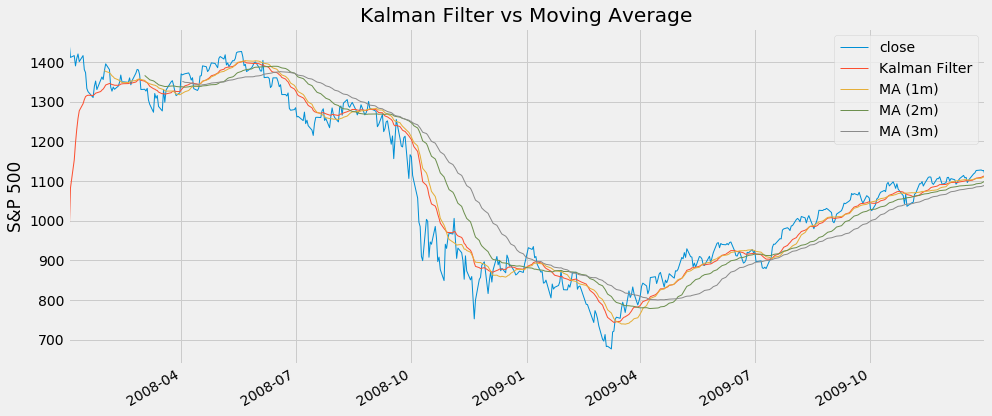

In [115]:
sp500_smoothed = sp500[['close']]
sp500_smoothed['Kalman Filter'] = state_means
for months in [1,2,3]:
    sp500_smoothed[f'MA ({months}m)'] = sp500.close.rolling(window=months*21).mean()

ax = sp500_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14,6), lw=1)
ax.set_xlabel('')
ax.set_ylabel('S&P 500')
plt.tight_layout();
plt.savefig('kalman_filter', dpi=300)

## Wavelets

In [64]:
import itertools
import matplotlib.pyplot as plt
import pywt

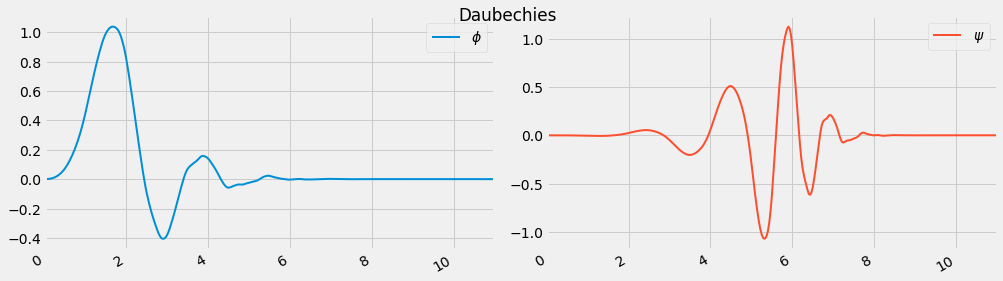

In [81]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=5)
df = pd.DataFrame({'$\phi$': phi, '$\psi$': psi}, index=x)
df.plot(title='Daubechies', subplots=True, layout=(1, 2), figsize=(14, 4), lw=2)
plt.tight_layout()
plt.savefig('daubechies', dpi=300);

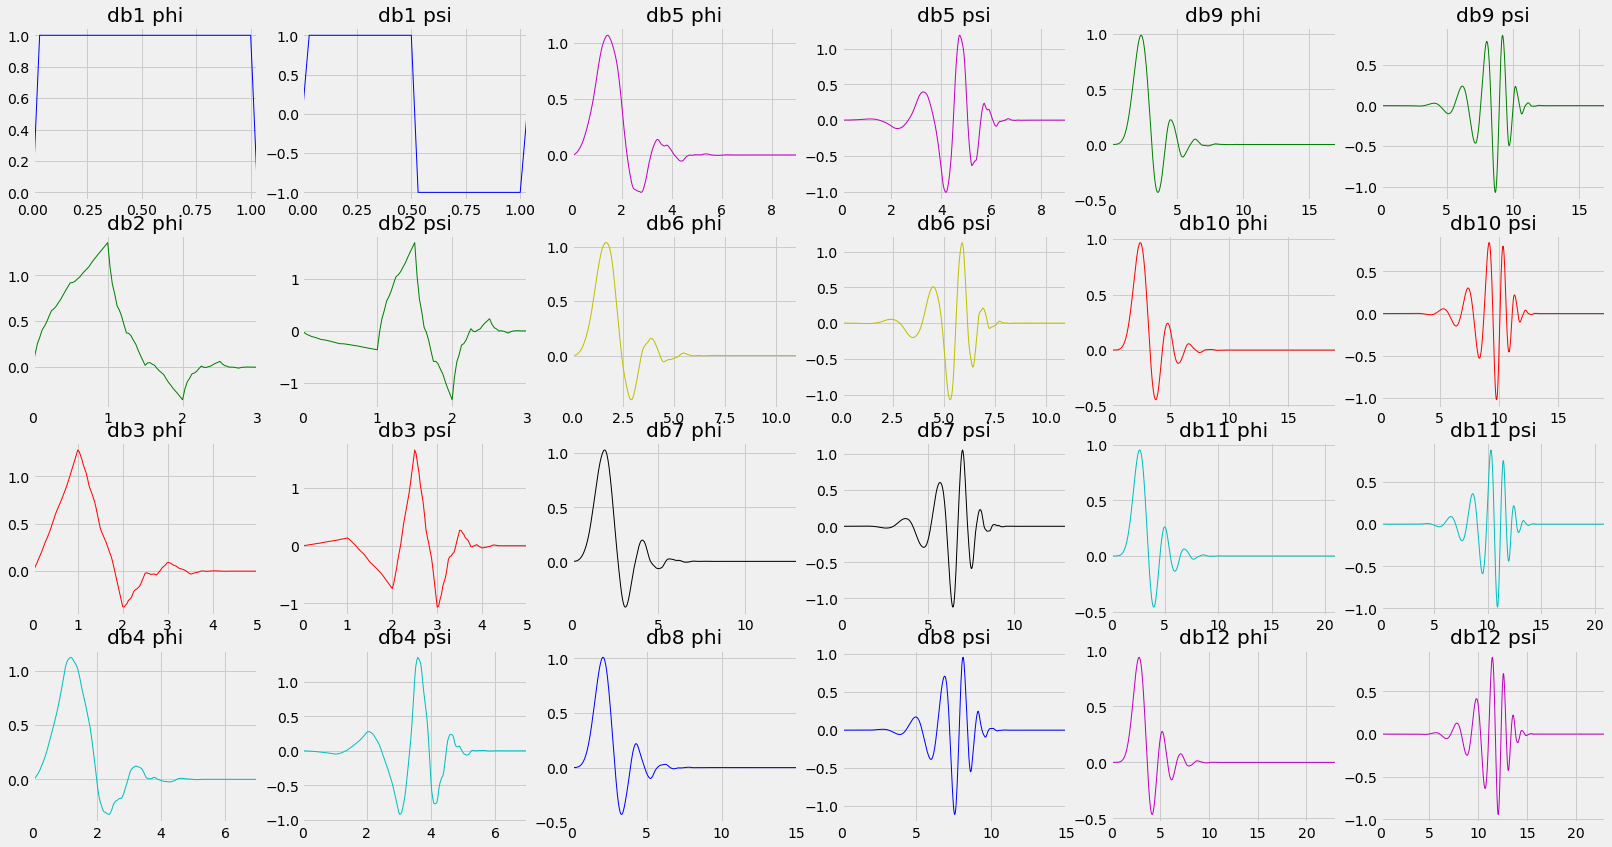

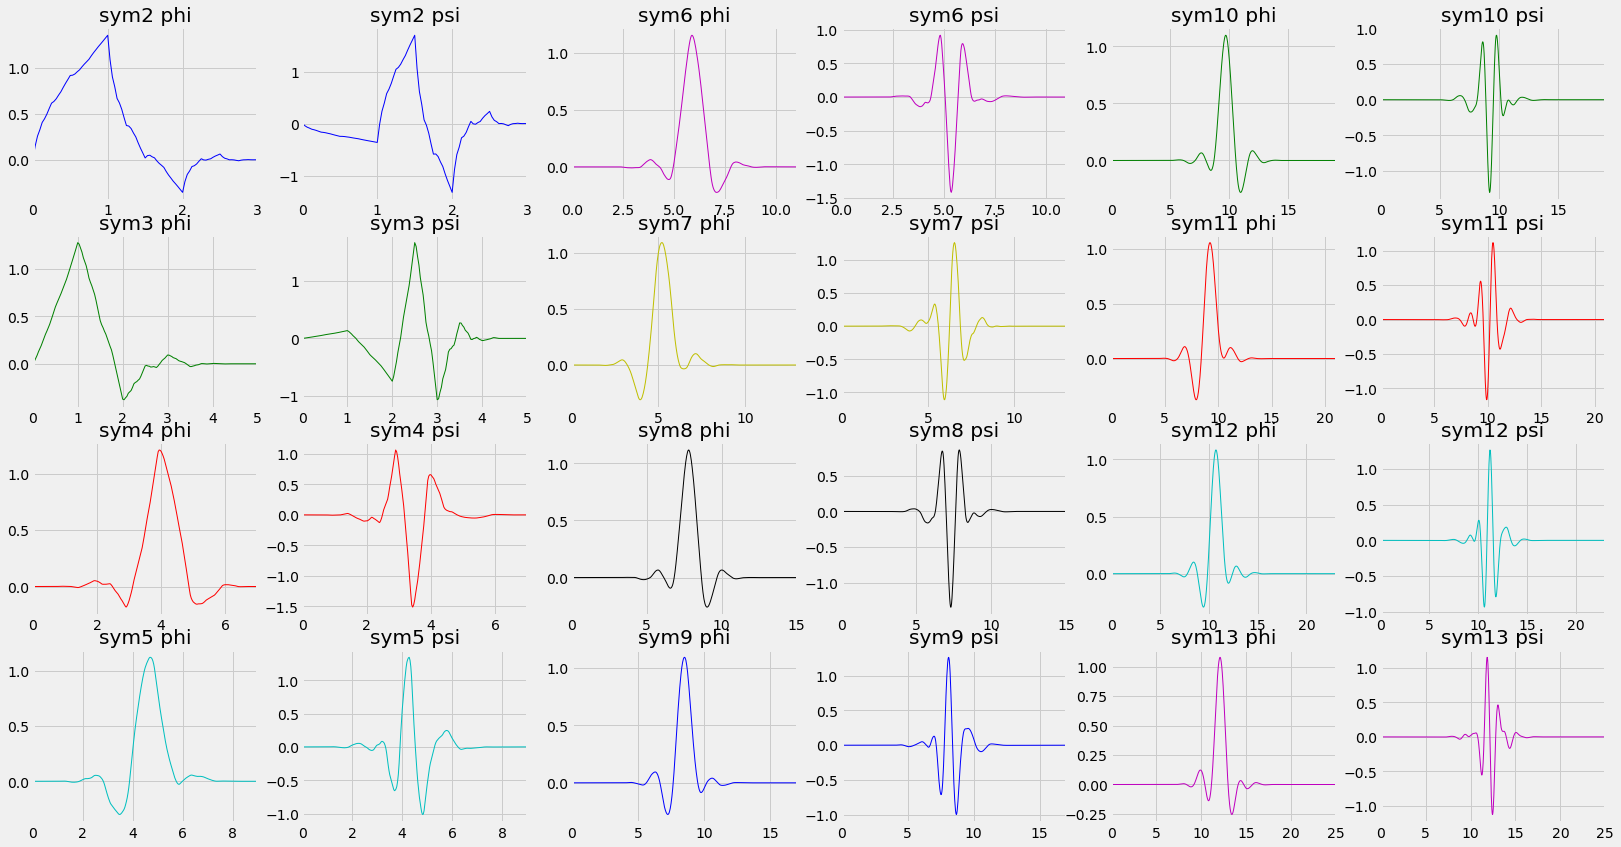

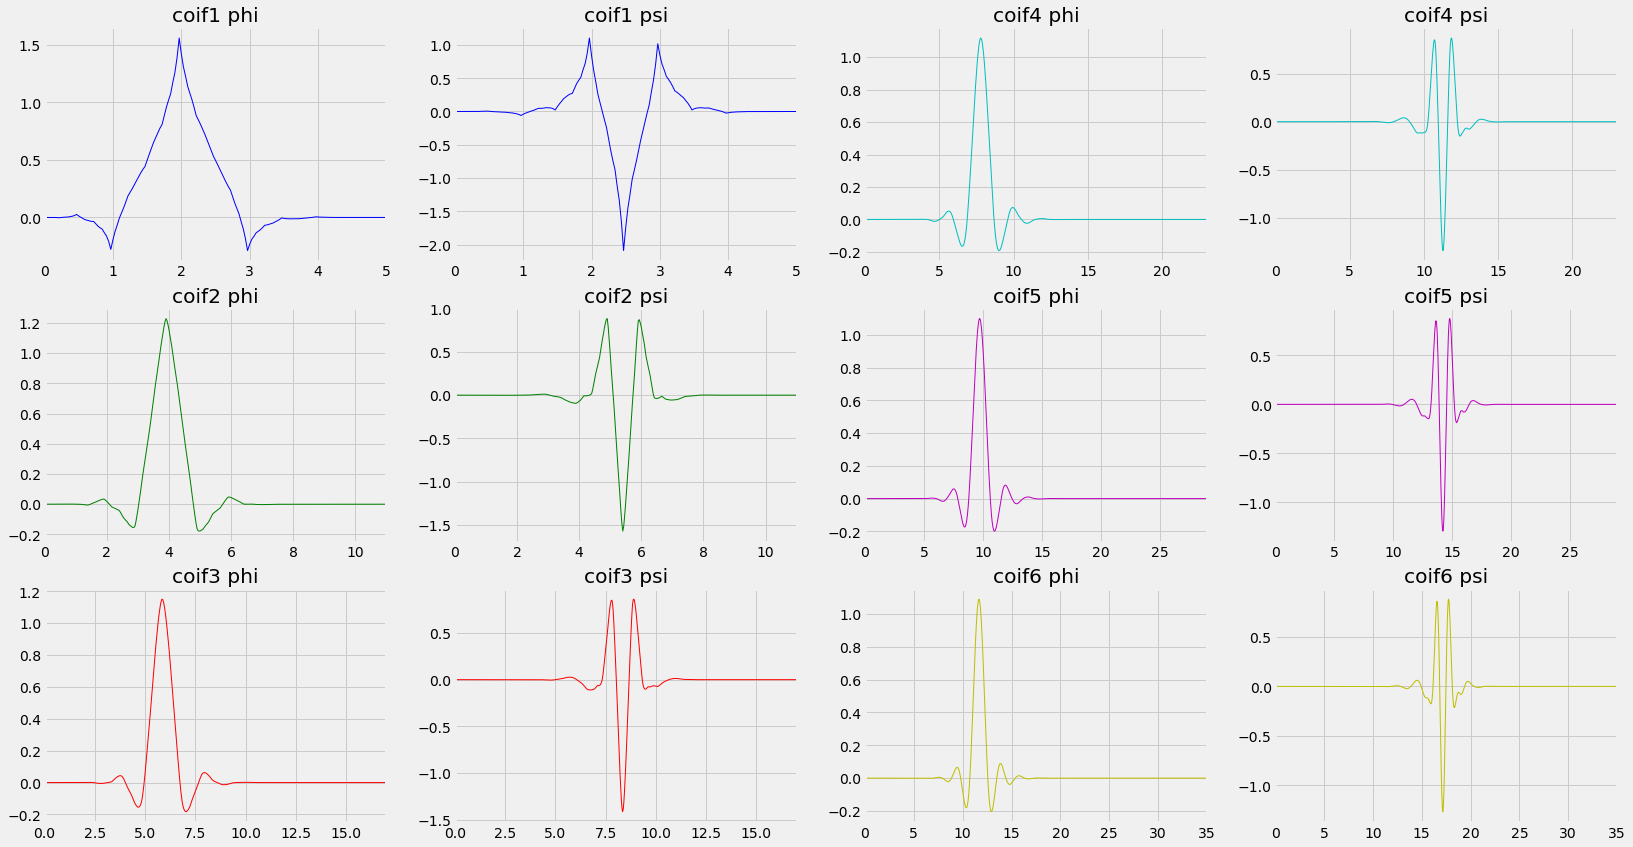

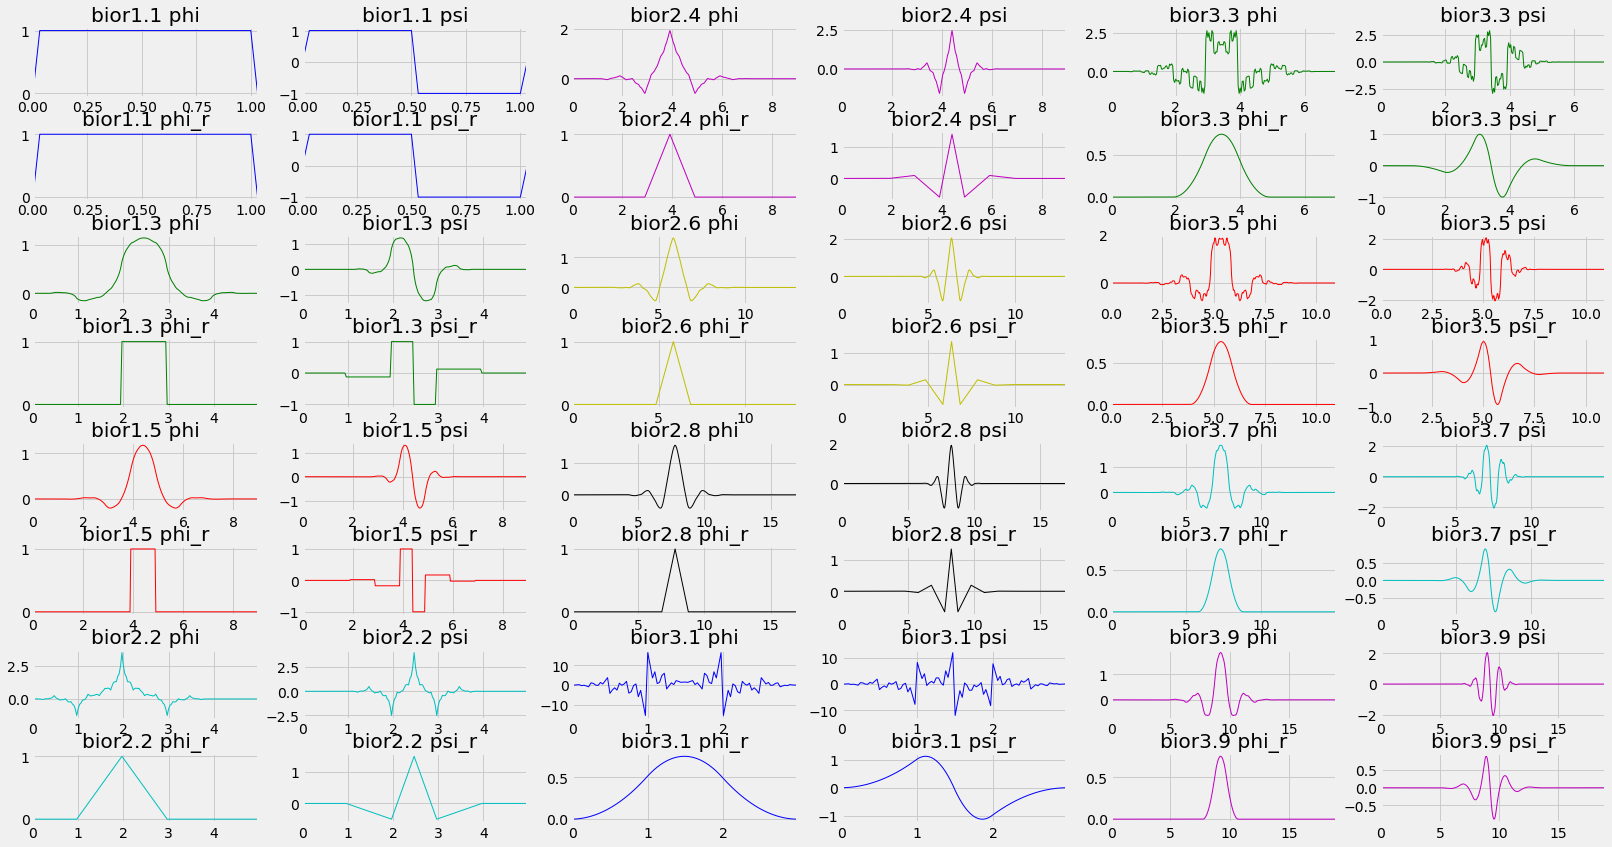

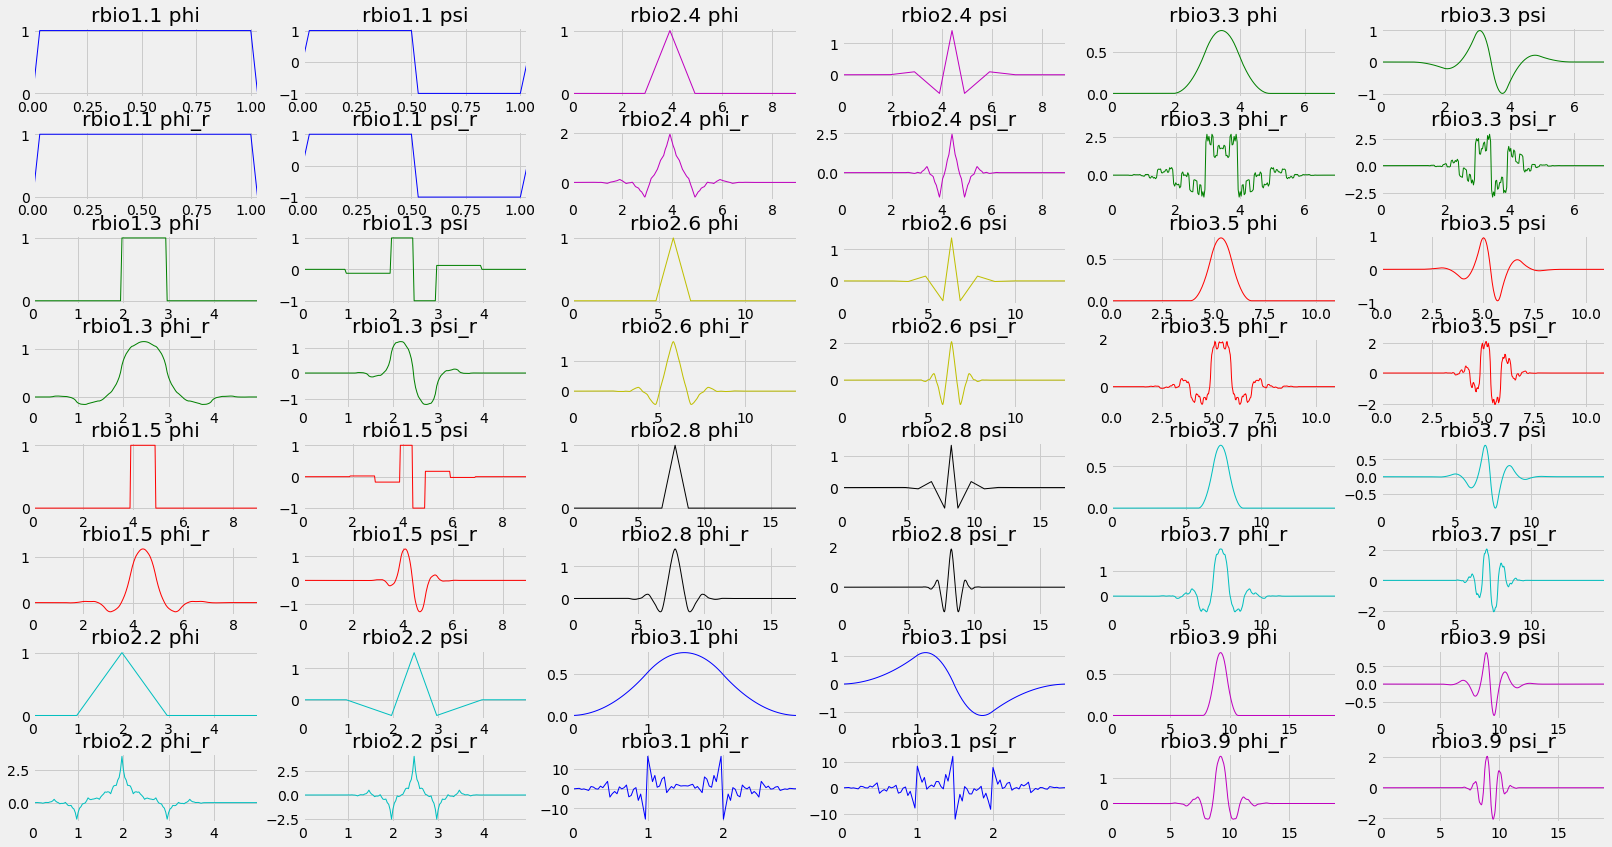

In [70]:
plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))

plt.show()

In [63]:
import pywt
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

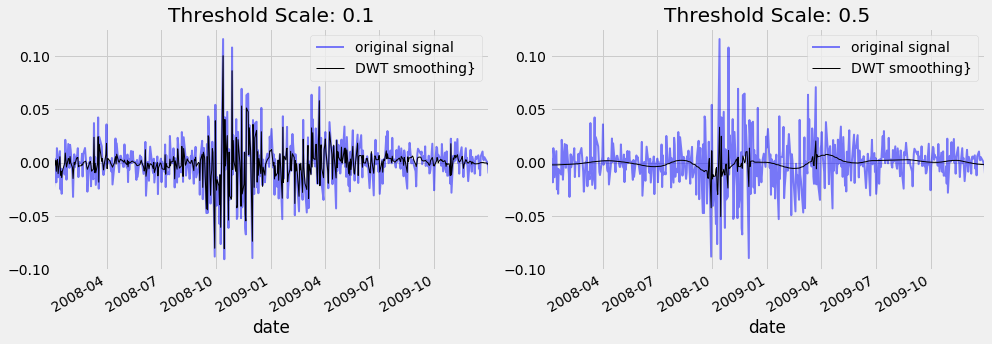

In [61]:
signal = (pd.read_hdf(DATA_STORE, 'sp500/prices')
          .loc['2008': '2009']
          .close.pct_change()
          .dropna())

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

wavelet = "db6"
for i, scale in enumerate([.1, .5]):
    
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2, 
                 title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])
    axes[i].legend()
fig.tight_layout()
fig.savefig('wavelets', dpi=300);